Giuliana Prado Peixoto

Projeto 2 - Modelo Não-Supervisionado

Selecionar dois datasets, aplicar um modelo neural não supervisionado e avaliar os padrões detectados em cada conjunto (clusters, outliers, homogeneidade), e variar os parâmetros no modelo.

Link dataset 1: https://archive.ics.uci.edu/dataset/763/land+mines-1

Link dataset 2: https://archive.ics.uci.edu/dataset/186/wine+quality

In [161]:
#!pip install ucimlrepo

In [162]:
#!pip install minisom

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from numpy.linalg import norm
np.random.seed(42)

# Dataset: Land Mines

Dados dos clientes de um mercado, com informações sobre como eles compram.

In [164]:
# fetch dataset
land_mines = fetch_ucirepo(id=763)

# data (as pandas dataframes)
X = land_mines.data.features
y = land_mines.data.targets

# metadata
print(land_mines.metadata)

# variable information
print(land_mines.variables)


{'uci_id': 763, 'name': 'Land Mines', 'repository_url': 'https://archive.ics.uci.edu/dataset/763/land+mines-1', 'data_url': 'https://archive.ics.uci.edu/static/public/763/data.csv', 'abstract': 'Detection of mines buried in the ground is very important in terms of safety of life and property. Many different methods have been used in this regard; however, it has not yet been possible to achieve 100% success. Mine detection process consists of sensor design, data analysis and decision algorithm phases. The magnetic anomaly method works according to the principle of measuring the anomalies resulting from the object in the magnetic field that disturbs the structure of it, the magnetic field, and the data obtained at this point are used to determine the conditions such as motion and position. The determination of parameters such as position, depth or direction of motion using magnetic anomaly has been carried out since 1970.', 'area': 'Engineering', 'tasks': ['Classification', 'Clustering']

In [165]:
y.value_counts()

,count
M,
1,71
2,70
3,66
4,66
5,65


In [166]:
# Normalizar os atributos para [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


Irei avaliar o Erro de Quantização, que avalia a qualidade da representação; Erro Topográfico, que avalia a preservação da topologia;

In [167]:
def treinar_e_avaliar_som(X, x_grid, y_grid, learning_rate, sigma, num_iter):
    som = MiniSom(x_grid, y_grid, X.shape[1], sigma=sigma, learning_rate=learning_rate)
    som.random_weights_init(X)
    som.train_random(X, num_iter)

    # Quantization error
    q_error = som.quantization_error(X)

    # Topographic error (0 = perfeito)
    t_error = som.topographic_error(X)

    return som, q_error, t_error


In [168]:
# variando os parâmetros da rede pra escolher o modelo com menor erro de quantização
# 25, 100 e 64 neurônios

parametros = [
    {'x_grid':5, 'y_grid':5, 'learning_rate':0.1, 'sigma':0.5, 'num_iter':1000},
    {'x_grid':10, 'y_grid':10, 'learning_rate':0.05, 'sigma':0.3, 'num_iter':2000},
    {'x_grid':8, 'y_grid':8, 'learning_rate':0.2, 'sigma':0.7, 'num_iter':1500},
]

resultados = []

for i, params in enumerate(parametros):
    som, qe, te = treinar_e_avaliar_som(X_scaled, **params)
    print(f"Teste {i+1}: QE={qe:.4f}, TE={te:.4f}, Params={params}")
    resultados.append({'som': som, 'qe': qe, 'te': te, **params})


Teste 1: QE=0.1490, TE=0.7189, Params={'x_grid': 5, 'y_grid': 5, 'learning_rate': 0.1, 'sigma': 0.5, 'num_iter': 1000}
Teste 2: QE=0.0748, TE=0.9438, Params={'x_grid': 10, 'y_grid': 10, 'learning_rate': 0.05, 'sigma': 0.3, 'num_iter': 2000}
Teste 3: QE=0.1006, TE=0.6627, Params={'x_grid': 8, 'y_grid': 8, 'learning_rate': 0.2, 'sigma': 0.7, 'num_iter': 1500}


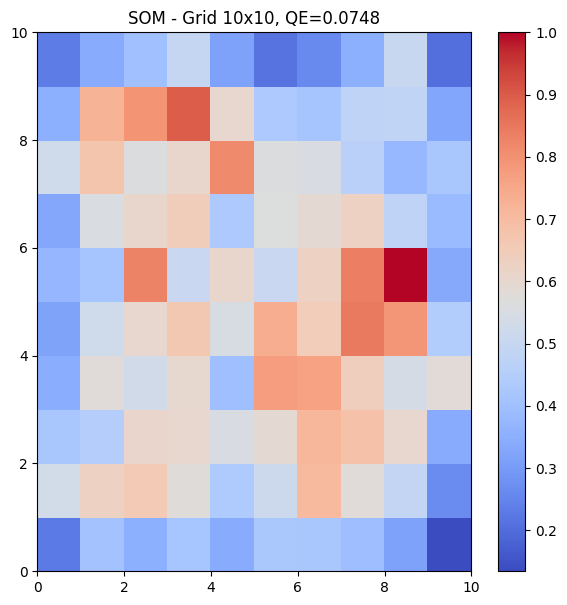

In [169]:

# Escolher o modelo com menor quantization error
melhor = min(resultados, key=lambda x: x['qe'])
som = melhor['som']

plt.figure(figsize=(7,7))
plt.title(f"SOM - Grid {melhor['x_grid']}x{melhor['y_grid']}, QE={melhor['qe']:.4f}")

# Mapa de distância (U-Matrix)
plt.pcolor(som.distance_map().T, cmap='coolwarm')
plt.colorbar()
plt.show()


Esse grid mostra, para cada neurônio, a distância média entre seus pesos e os pesos dos neuônios vizinhos. A cor azul indica que são distâncias pequenas, ou seja o neurônio é parecido com os seus vizinho (estão em um cluster). A cor vermelha/alaranjada indica que ele é muito diferente dos vizinhos, que representa a fronteira entre os clusters. Manchas isoladas vermelhas podem ser outliers. Esse é o grid 10x10, com 100 neurônios, e foi o que obteve melhor desempenho das três variações de parâmetros testados.

Para encontrar outiliers, vou considerar as amostras que apresentaram distancia ao BMU (Best Matching Unit, o neurônio mais parecido com uma amostra de dado) acima do percentil 95. São dados bem afastados da malha de neurônios, indicando padrões atípicos, outlier.

In [170]:
# Calcular distância de cada ponto ao seu neurônio vencedor
distancias = np.array([norm(x - som.get_weights()[som.winner(x)]) for x in X_scaled])

# Threshold: ex. top 5% maiores distâncias = outliers
limite = np.percentile(distancias, 95)
outliers_idx = np.where(distancias > limite)[0]

print(f"Número de outliers detectados: {len(outliers_idx)}")


Número de outliers detectados: 17


Para avaliar a homogeneidade, para cada neurônio, veremos quantos dados caíram nele e quais são os rótulos nesses dados. Apesar de ser aprendizado não supervisionado, o dataset tem o y com os targets, que nos permite fazer isso. Maior homogeneidade se a maioria dos dados mapeados naquele neurônio possuem o mesmo target. Para esse dataset, deu 69%, que indica que os clusters formados são razoavelmente homogêneos.

In [171]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Mapeia BMUs para rótulos reais
bmu_rotulos = defaultdict(list)
for i, x in enumerate(X_scaled):
    bmu = som.winner(x)
    bmu_rotulos[bmu].append(int(y.iloc[i]))  # rótulo real

# Calcula pureza de cada neurônio
purezas = []
for bmu, rotulos in bmu_rotulos.items():
    mais_comum = max(set(rotulos), key=rotulos.count)
    pureza = rotulos.count(mais_comum) / len(rotulos)
    purezas.append(pureza)

# Média da pureza de todos os neurônios ativados
homogeneidade_media = np.mean(purezas)
print(f"Homogeneidade média dos neurônios ativados: {homogeneidade_media:.2f}")


Homogeneidade média dos neurônios ativados: 0.69


/tmp/ipython-input-171-3263042728.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  bmu_rotulos[bmu].append(int(y.iloc[i]))  # rótulo real


CONCLUSÃO: Testamos múltiplas configurações da rede SOM, variando o tamanho da grade, taxa de aprendizado e número de iterações. O melhor modelo foi selecionado com base no menor erro de quantização, que indica uma representação mais precisa dos dados.  A detecção de outliers pelo erro de quantização individual permitiu reconhecer instâncias atípicas que podem representar dados ruidosos ou raros. A avaliação da homogeneidade dos clusters, realizada por meio da análise da consistência dos rótulos reais associados (presença ou ausência de mina), mostrou uma boa correspondencia, confirmando que o SOM organizou os dados de forma eficaz, agrupando amostras similares em neurônios próximos.

# Dataset: Wine Quality

In [172]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [173]:
X

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8


fixed_acidity


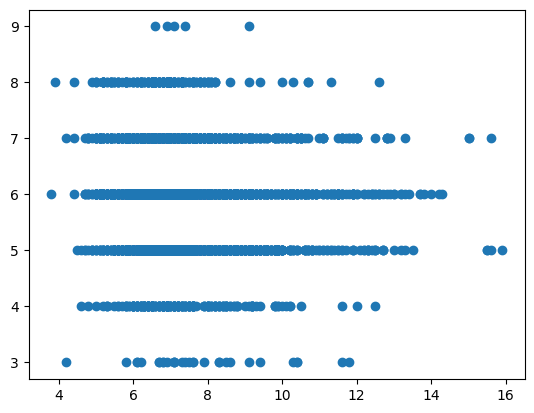

volatile_acidity


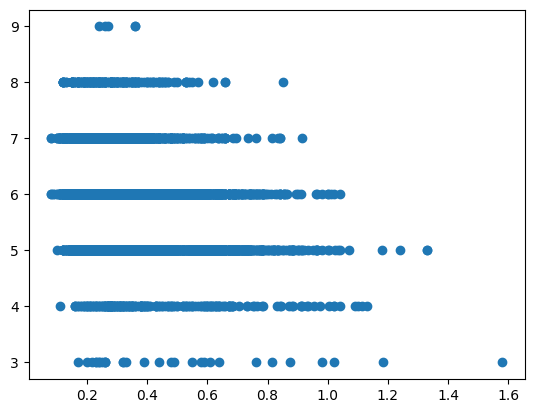

citric_acid


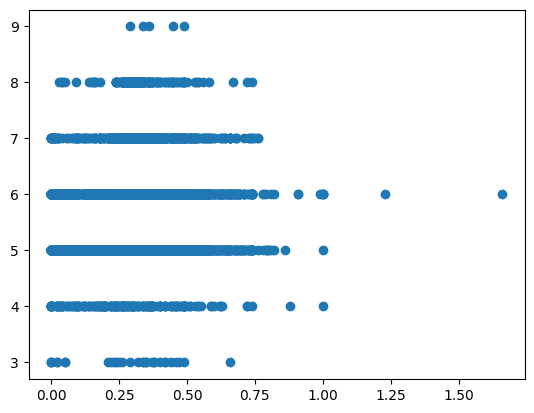

residual_sugar


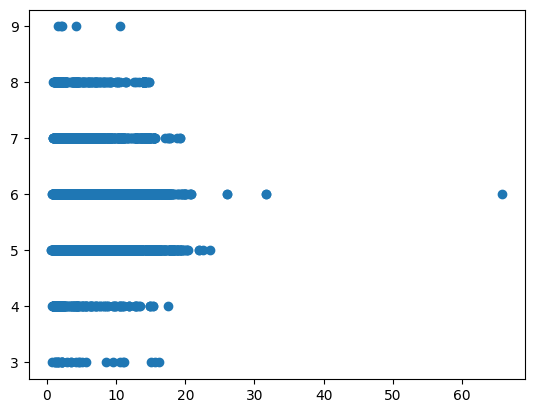

chlorides


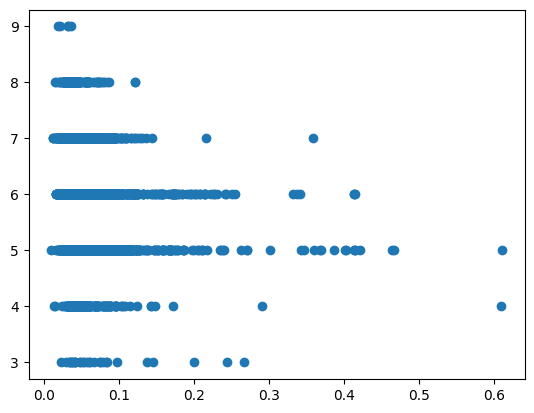

free_sulfur_dioxide


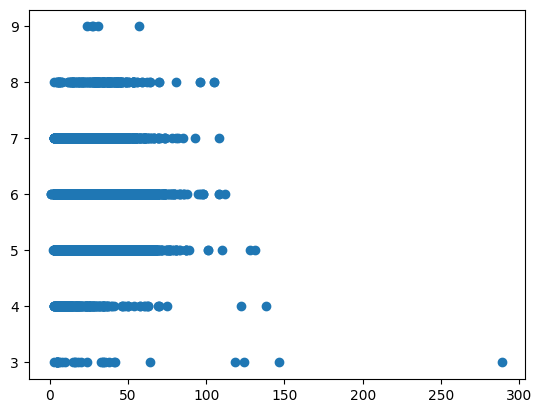

total_sulfur_dioxide


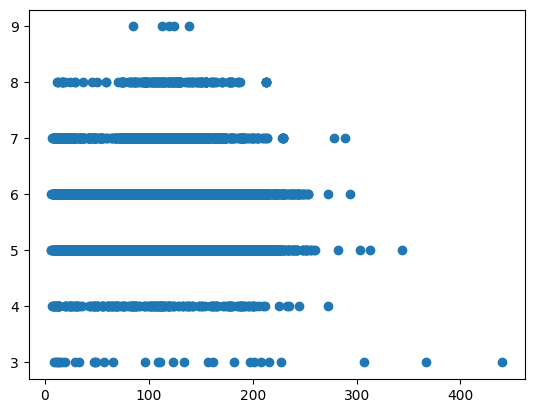

density


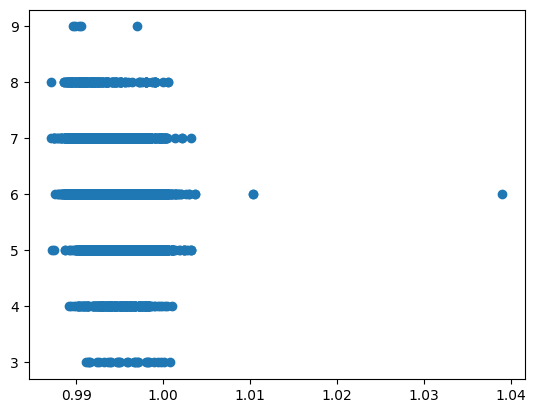

pH


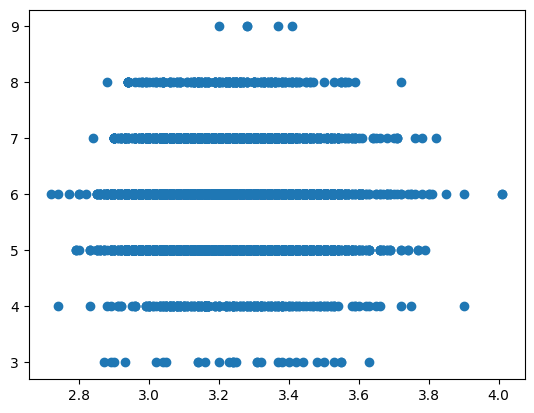

sulphates


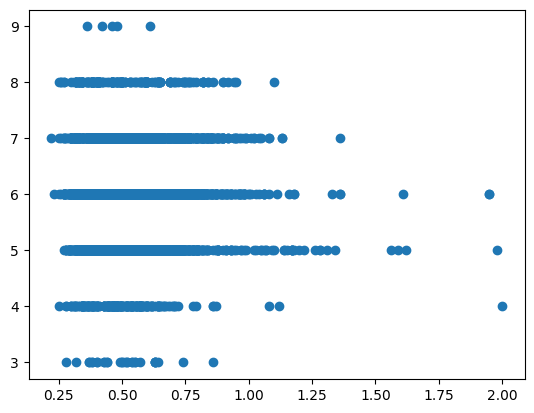

alcohol


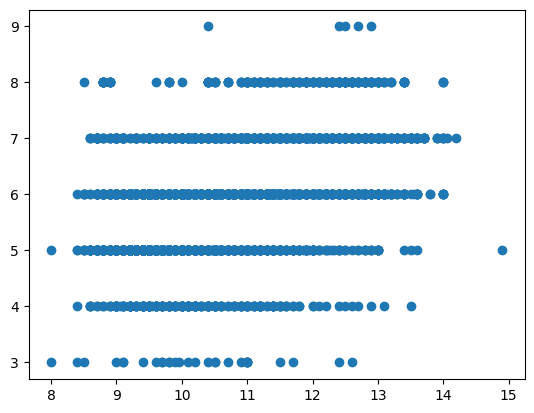

In [174]:
for column in X.columns:
  print(column)
  plt.scatter(X[column],y)
  plt.show()

In [175]:
y.value_counts()

,count
quality,
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


In [176]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)



=== SOM 1: Grid 6x6, LR=0.5, Iter=1000 ===
Erro de Quantização: 0.2771


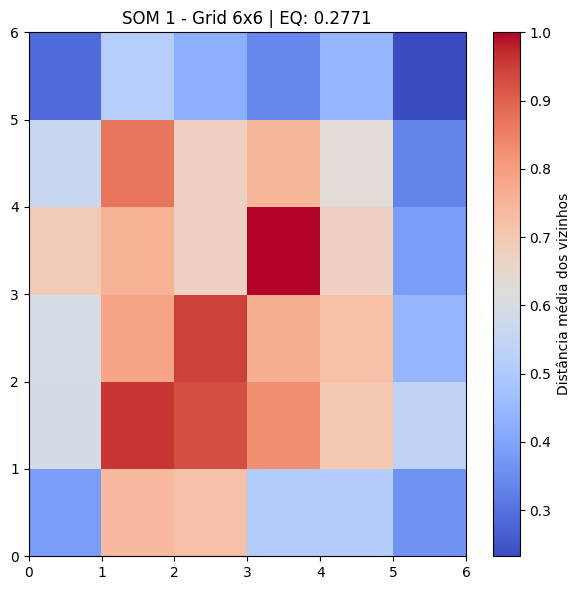


=== SOM 2: Grid 8x8, LR=0.3, Iter=1500 ===
Erro de Quantização: 0.2493


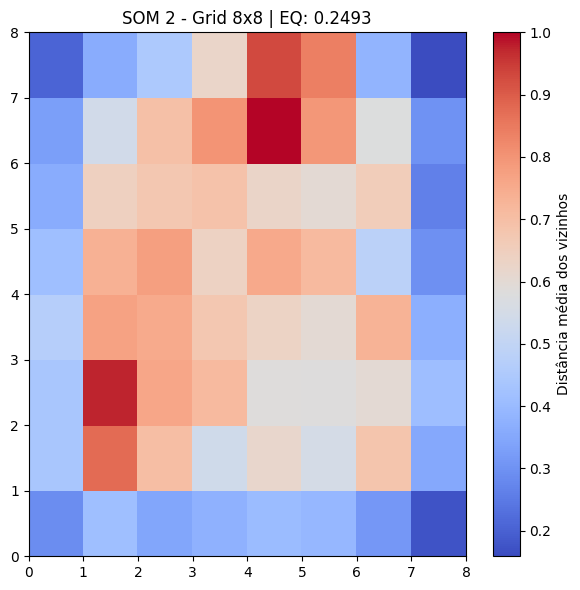


=== SOM 3: Grid 10x10, LR=0.2, Iter=2000 ===
Erro de Quantização: 0.1784


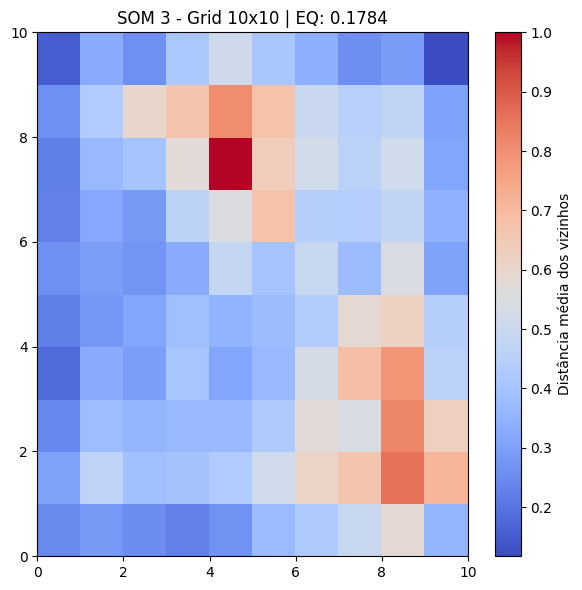


 Melhor configuração:
Grid: 10x10, LR=0.2, Iter=2000
Erro de Quantização: 0.1784


In [177]:
def treinar_som(X_scaled, x, y, lr, it):
    som = MiniSom(x=x, y=y, input_len=X_scaled.shape[1], sigma=1.0, learning_rate=lr, random_seed=42)
    som.random_weights_init(X_scaled)
    som.train(X_scaled, it, verbose=False)
    return som

def calcular_erro_quantizacao(som, X_scaled):
    return np.mean([norm(x - som.get_weights()[som.winner(x)]) for x in X_scaled])

# Configurações diferentes
configs = [
    {'x': 6, 'y': 6, 'lr': 0.5, 'it': 1000},
    {'x': 8, 'y': 8, 'lr': 0.3, 'it': 1500},
    {'x':10, 'y':10, 'lr': 0.2, 'it': 2000},
]

resultados = []

# Treinar, calcular EQ, plotar grids
for i, cfg in enumerate(configs, 1):
    print(f"\n=== SOM {i}: Grid {cfg['x']}x{cfg['y']}, LR={cfg['lr']}, Iter={cfg['it']} ===")
    som = treinar_som(X_scaled, cfg['x'], cfg['y'], cfg['lr'], cfg['it'])

    # Erro de quantização
    eq = calcular_erro_quantizacao(som, X_scaled)
    resultados.append((cfg, eq))
    print(f"Erro de Quantização: {eq:.4f}")

    # U-Matrix (mapa de distâncias)
    plt.figure(figsize=(6, 6))
    plt.title(f"SOM {i} - Grid {cfg['x']}x{cfg['y']} | EQ: {eq:.4f}")
    plt.pcolor(som.distance_map().T, cmap='coolwarm')
    plt.colorbar(label='Distância média dos vizinhos')
    plt.tight_layout()
    plt.show()

# Melhor configuração
melhor_cfg, menor_eq = min(resultados, key=lambda x: x[1])
print("\n Melhor configuração:")
print(f"Grid: {melhor_cfg['x']}x{melhor_cfg['y']}, LR={melhor_cfg['lr']}, Iter={melhor_cfg['it']}")
print(f"Erro de Quantização: {menor_eq:.4f}")

O melhor grid foi o 10x10, com menor erro de quantização.

In [178]:
# Para cada dado, calcula a distância até seu BMU (erro de quantização individual)
distancias = np.array([norm(x - som.get_weights()[som.winner(x)]) for x in X_scaled])


# Define threshold para outlier (ex: acima de média + 2 * desvio padrão)
limite = np.mean(distancias) + 2 * np.std(distancias)
outlier_indices = np.where(distancias > limite)[0]

print(f"Total de outliers detectados: {len(outlier_indices)}")

# Visualiza os 5 principais outliers
df_outliers = pd.DataFrame(X.iloc[outlier_indices])
df_outliers['Erro Quantização'] = distancias[outlier_indices]
print(df_outliers.sort_values(by='Erro Quantização', ascending=False).head())

Total de outliers detectados: 207
      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
4380            7.8             0.965         0.60            65.8      0.074   
6344            6.1             0.260         0.25             2.9      0.047   
151             9.2             0.520         1.00             3.4      0.610   
2344            7.4             0.200         1.66             2.1      0.022   
4751            7.6             0.250         1.23             4.6      0.035   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
4380                  8.0                 160.0  1.03898  3.39       0.69   
6344                289.0                 440.0  0.99314  3.44       0.64   
151                  32.0                  69.0  0.99960  2.74       2.00   
2344                 34.0                 113.0  0.99165  3.26       0.55   
4751                 51.0                 294.0  0.99018  3.03       0.43   

      alcohol  E

Foram detectados 207 outliers nesse dataset.

Para avaliar a homogeneidade, será utilizado o mesmo método que o anterior, comparando os dados que froam agrupados possuem o mesmo rótulo. Para esse dataset, deu 60%, que indica que os clusters formados são razoavelmente homogêneos.

In [179]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Mapeia BMUs para rótulos reais (qualidade do vinho)
bmu_rotulos = defaultdict(list)
for i, x in enumerate(X_scaled):
    bmu = som.winner(x)
    bmu_rotulos[bmu].append(int(y.iloc[i]))  # rótulo real

# Calcula pureza de cada neurônio
purezas = []
for bmu, rotulos in bmu_rotulos.items():
    mais_comum = max(set(rotulos), key=rotulos.count)
    pureza = rotulos.count(mais_comum) / len(rotulos)
    purezas.append(pureza)

# Média da pureza de todos os neurônios ativados
homogeneidade_media = np.mean(purezas)
print(f"Homogeneidade média dos neurônios ativados: {homogeneidade_media:.2f}")


/tmp/ipython-input-179-1947363473.py:8: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  bmu_rotulos[bmu].append(int(y.iloc[i]))  # rótulo real


Homogeneidade média dos neurônios ativados: 0.60


CONCLUSÃO: Aplicamos o modelo de Self-Organizing Map (SOM) para identificar padrões e agrupamentos no conjunto de dados Wine Quality. Após testar três configurações de rede (grades 6×6, 8×8 e 10×10), a grade 10×10 apresentou o menor erro de quantização, sendo, portanto, a mais adequada para representar a estrutura dos dados. Adicionalmente, foi possível detectar outliers por meio da análise do erro de quantização individual: instâncias com distância significativamente maior ao seu neurônio vencedor foram consideradas anomalias. Por fim, avaliamos a homogeneidade dos agrupamentos verificando a consistência dos rótulos reais (notas de qualidade dos vinhos) em cada neurônio ativado. A média de pureza dos clusters formados foi satisfatória, indicando que o SOM foi capaz de organizar os dados de forma coerente, agrupando amostras com características e classificações semelhantes.